In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today()
from matplotlib.ticker import ScalarFormatter

In [4]:
def Black_Scholes_price(S, K, T, r, q, sigma, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * q * np.exp(-q * T) * norm.cdf(d2) 
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, theta, vega

In [6]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [8]:
def find_arbitrage(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    expiration = ticker.options[1]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    #calls = calls[calls.openInterest >= 50]
    puts = option_chain.puts
    #puts = puts[puts.openInterest >= 50]

    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    current_price = ticker.info['currentPrice']
    calls['CurrentPrice'] = current_price
    dividends = ticker.dividends.iloc[-1] if not ticker.dividends.empty else 0
    
    risk_free_rate = Get_rfr()
    for df in [calls, puts]:
        df['TheoreticalPrice'],df['delta'],df['gamma'],df['theta'],df['vega'] = np.where(
            (df['openInterest'] > 50),
            Black_Scholes_price(current_price, df['strike'], (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365,
                                        risk_free_rate, dividends, df['impliedVolatility'], df['contractType'].iloc[0]),
            np.nan
        )
    '''
    ------------------------------------------------------------------------------------------------------------------------------------
    HERE!!! we use lastPrice for demonstration purpose, you should be using ask or bit
    (or use something better)
    ------------------------------------------------------------------------------------------------------------------------------------
    '''
    
    calls['Discrepancy'] = calls['lastPrice'] - calls['TheoreticalPrice']
    puts['Discrepancy'] = puts['lastPrice'] - puts['TheoreticalPrice']

    calls['sign'] = np.where(calls['Discrepancy'] > 0, 1, -1) #overprice -> sell = +1, underprice -> buy = -1
    puts['sign'] = np.where(puts['Discrepancy'] > 0, 1, -1)

    Option_price_threshold = 0.05 # % difference
    significant_calls = calls[abs(calls['Discrepancy']) > calls['lastPrice']*Option_price_threshold]
    significant_puts = puts[abs(puts['Discrepancy']) > puts['lastPrice']*Option_price_threshold]

    print(f'The current price for {ticker_symbol} is {current_price},')
    print(f"Found {len(significant_calls)} potential call arbitrage opportunities")
    print(f"Found {len(significant_puts)} potential put arbitrage opportunities")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(calls['strike'], calls['Discrepancy'], label='Calls', alpha=0.5)
    plt.scatter(puts['strike'], puts['Discrepancy'], label='Puts', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Discrepancy ($)')
    plt.title(f'Option price discrepancy for {ticker_symbol}')
    plt.legend()
    plt.show()
    
    return significant_calls, significant_puts

The current price for NVDA is 124.04,
Found 54 potential call arbitrage opportunities
Found 72 potential put arbitrage opportunities


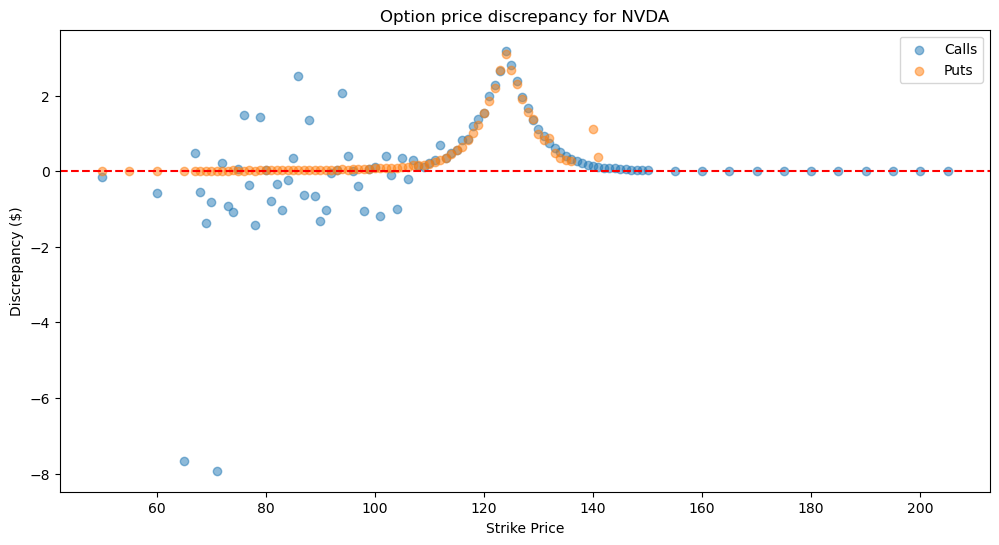


Top 5 Call Arbitrage Opportunities:
----------------------------------------
         contractSymbol             lastTradeDate  strike  lastPrice  bid  \
61  NVDA241004C00124000 2024-09-26 19:59:57+00:00   124.0       3.30  0.0   
62  NVDA241004C00125000 2024-09-26 19:59:59+00:00   125.0       2.82  0.0   
60  NVDA241004C00123000 2024-09-26 19:59:59+00:00   123.0       3.75  0.0   

    ask  change  percentChange  volume  openInterest  ...  currency  \
61  0.0     0.0            0.0   22961         13142  ...       USD   
62  0.0     0.0            0.0   59395         38207  ...       USD   
60  0.0     0.0            0.0   26966         13941  ...       USD   

    contractType CurrentPrice TheoreticalPrice     delta     gamma     theta  \
61          call       124.04         0.115174  1.000000  0.000000 -0.058102   
62          call       124.04         0.000012  0.000198  0.003022 -0.005696   
60          call       124.04         1.114403  1.000000  0.000000 -0.057633   

       

In [10]:
Stock = "NVDA"
significant_calls, significant_puts = find_arbitrage(Stock)
all_options = pd.concat([significant_calls,significant_puts])

# Display the top 5 arbitrage opportunities for calls and puts
print("\nTop 5 Call Arbitrage Opportunities:")
print('----------------------------------------')
print(significant_calls.sort_values('Discrepancy', ascending=False).head(3))
print("=======================================================================================")
print("\nTop 5 Put Arbitrage Opportunities:")
print('-----------------------------------------')
print(significant_puts.sort_values('Discrepancy', ascending=False).head(3))

In [12]:
#Instant Delta hedging:
def Create_Delta_hedging(options):
    if options.empty:
        print("No arbitrage found")
        return pd.DataFrame()
    
    portfolio = options.copy()
    
    portfolio['share volume'] = portfolio['delta'] * portfolio['volume']
    portfolio['share volume'] = portfolio['share volume'].where(portfolio['share volume'] >= 1, 0) # please at least buy one share thx
    
    portfolio['stock invested'] = portfolio['share volume'] * portfolio['CurrentPrice']
    
    portfolio['cash flow'] = portfolio['sign'] * portfolio['lastPrice'] * portfolio['volume']
    
    return portfolio

Pi = Create_Delta_hedging(all_options)

In [22]:
Total_cash_flow = Pi['cash flow'].sum() if not Pi.empty else 0
Require_stock = Pi['stock invested'].sum() if not Pi.empty else 0
print(f'Total cash flow is {Total_cash_flow:.3e} USD')
print(f'Inversted stock worth {Require_stock:.3e} USD')
print(f'Cash flow to required cash ratio: {Total_cash_flow/Require_stock*100:.3f}%') if Require_stock != 0 else print("No arbitrage")

Total cash flow is 1.375e+06 USD
Inversted stock worth 1.095e+07 USD
Cash flow to required cash ratio: 12.555%


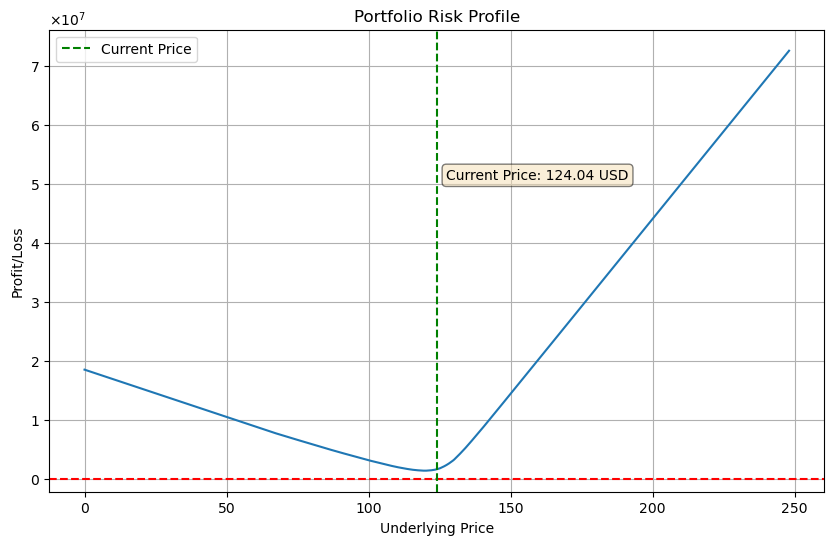

Minimum profit (or maximum loss) is 1.421e+06 USD from initial cost 1.095e+07 USD (could be worse, look at the graph)
Minimum profit (or maximum loss) %: 12.98%


In [28]:
def Portfolio_risk(portfolio):
    if portfolio.empty:
        print("No arbitrage, no profit, not risk")
        return pd.DataFrame()
    base_price = portfolio["CurrentPrice"].iloc[0]
    grid_size = 2**11
    possible_prices = np.linspace(0, base_price*2, grid_size)
    Profits = np.zeros(len(possible_prices))

    initial_stock_invested = portfolio['stock invested'].sum()
    
    for i, price in enumerate(possible_prices):
        
        call_profit = portfolio[portfolio['contractType'] == 'call']['volume'] * \
                      np.maximum(price - portfolio[portfolio['contractType'] == 'call']['strike'], 0)
        
        put_profit = portfolio[portfolio['contractType'] == 'put']['volume'] * \
                     np.maximum(portfolio[portfolio['contractType'] == 'put']['strike'] - price, 0)
        
        Profits[i] = (call_profit.sum() + put_profit.sum() + #Profit from options
                      portfolio['cash flow'].sum() + #Profit from option arbitrage (Could be negative if we spend a lot in buying options)
                      price * portfolio['share volume'].sum() - #Stock worth
                      initial_stock_invested) # intial stock invested


#--------------------------------------------------------------------------------------------------------------------------------------
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(possible_prices, Profits)
    plt.title('Portfolio Risk Profile')
    plt.xlabel('Underlying Price')
    plt.ylabel('Profit/Loss')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axvline(x=base_price, color='g', linestyle='--', label='Current Price')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.63, 0.7, f'Current Price: {base_price:.2f} USD', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='center', bbox=props)
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    
    print(f'Minimum profit (or maximum loss) is {min(Profits):.3e} USD from initial cost {initial_stock_invested:.3e} USD (could be worse, look at the graph)')
    if initial_stock_invested > 0:
        min_profit_percentage = min(Profits) / initial_stock_invested * 100
        print(f'Minimum profit (or maximum loss) %: {min_profit_percentage:.2f}%')
    elif initial_stock_invested < 0:
        max_profit_percentage = min(Profits) / abs(initial_stock_invested) * 100
        print(f'Maximum profit %: {max_profit_percentage:.2f}%')
    else:
        print('Initial cost is zero. Cannot calculate percentage profit/loss.')
#--------------------------------------------------------------------------------------------------------------------------------------
    
Portfolio_risk(Pi)